# 1 Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

%matplotlib inline

In [2]:
mb_size = 100 # mini-batch size of 100

In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),
                                                 (0.5, 0.5, 0.5))])

In [4]:
# split dataset in trainset and testset. The trainset consists of 60000 images, the testset of 10000 imgs.

trainset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

testset = dset.MNIST("./", download = True,
                     train = False,
                     transform = trans)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)


In [6]:
classnames = [str(i) for i in range(10)]

def imshow(img, title="", cmap = "Greys_r"): #convert tensor to image
    plt.title(title)
    img = img / 2 + 0.5     # unnormalize
    numpyimg = img.numpy()[0]
    plt.imshow(numpyimg, cmap = cmap)
    

def display_10_images_from_dataset(dataset, class_names):
    """
    plots 10 randomly chosen images from a given dataset
    """
    display = [] #holds tuples of image and respective label
    for _ in range(10):
        index = np.random.randint(0,len(dataset)+1)
        display.append(dataset[index])
    
    nr = 1
    fig, axes = plt.subplots(2,5,sharex='col',sharey='row', figsize = (14,9))
    for image, label in display:
        axes[(nr-1)//5][(nr-1)%5] = plt.subplot(2,5,nr)
        plt.title(class_names[label], fontsize = 16)
        imshow(image, title = class_names[label])
        nr+=1
    fig.subplots_adjust(hspace=-0.4)
    plt.setp([a.get_xticklabels() for a in fig.axes[0:5]], visible=False)
    plt.setp([a.get_yticklabels() for a in fig.axes[1:5]+fig.axes[6:]], visible=False)
    plt.show()
    plt.savefig("previewMNIST.png")

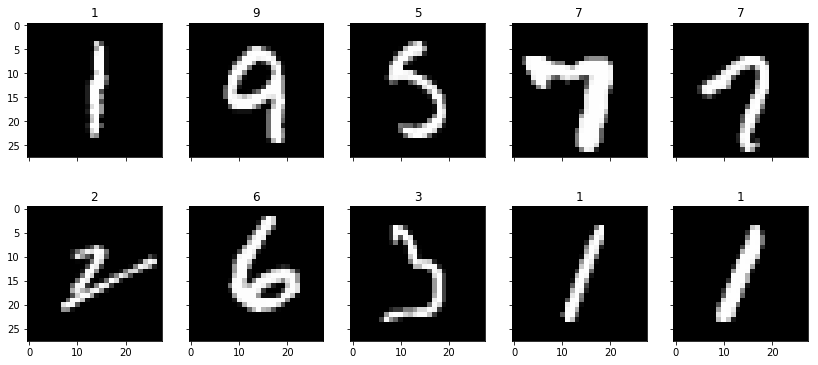

In [7]:
display_10_images_from_dataset(testset, classnames)

In [8]:
def init_weights(shape):
    # xavier initialization (a good initialization is important!)
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    fan_in = shape[0]
    fan_out = shape[1]
    variance = 2.0/(fan_in + fan_out)
    w = torch.randn(size=shape)*np.sqrt(variance)
    w.requires_grad = True
    return w

In [9]:
def rectify(X):
    return torch.max(torch.zeros_like(X), X)

In [10]:
# you can also use torch.nn.functional.softmax on future sheets
def softmax(X):
    c = torch.max(X, dim=1)[0].reshape(mb_size, 1)
    # this avoids a blow up of the exponentials
    # but calculates the same formula
    stabelized = X-c
    exp = torch.exp(stabelized)
    return exp/torch.sum(exp, dim=1).reshape(mb_size, 1)

In [11]:
# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.9, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(1 - alpha, grad, grad)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(-group['lr'], grad, avg)

In [32]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    #h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    #h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [33]:
w_h = init_weights((784, 50))
w_h2 = init_weights((50, 50))
w_o = init_weights((50, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

In [34]:
dataloader = trainloader

In [35]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    print('Loss: %.4f' % cost)
    optimizer.step()

Loss: 2.4778
Loss: 2.8132
Loss: 2.2816
Loss: 2.2995
Loss: 2.1588
Loss: 2.2253
Loss: 2.0827
Loss: 1.9358
Loss: 1.9803
Loss: 1.9186
Loss: 1.7410
Loss: 1.7339
Loss: 1.8249
Loss: 1.6397
Loss: 1.6444
Loss: 1.6895
Loss: 1.5673
Loss: 1.3740
Loss: 1.4253
Loss: 1.3858
Loss: 1.3975
Loss: 1.3086
Loss: 1.1707
Loss: 0.9304
Loss: 1.2828
Loss: 1.1762
Loss: 1.0824
Loss: 1.1135
Loss: 0.9949
Loss: 1.1272
Loss: 0.9650
Loss: 0.9824
Loss: 1.1068
Loss: 1.0798
Loss: 0.8536
Loss: 0.8355
Loss: 1.0288
Loss: 0.9916
Loss: 1.0291
Loss: 0.8135
Loss: 0.8980
Loss: 0.9110
Loss: 0.9535
Loss: 0.9614
Loss: 0.8859
Loss: 1.0265
Loss: 0.9178
Loss: 1.0005
Loss: 0.9681
Loss: 0.8342
Loss: 0.8430
Loss: 0.9363
Loss: 0.5884
Loss: 0.7888
Loss: 0.7987
Loss: 0.9753
Loss: 0.8285
Loss: 0.8730
Loss: 0.8362
Loss: 0.9468
Loss: 0.8570
Loss: 0.6032
Loss: 0.5639
Loss: 1.0434
Loss: 0.5468
Loss: 0.5439
Loss: 0.6812
Loss: 0.6342
Loss: 0.9023
Loss: 0.7769
Loss: 0.5918
Loss: 0.5784
Loss: 0.5076
Loss: 0.6765
Loss: 0.5272
Loss: 0.6144
Loss: 0.8333

# 2 Dropout

In [36]:
def dropout1(X, p_drop=1.):
    if 0 < p_drop < 1:
        phi = torch.tensor(np.random.binomial(1, p_drop, X.size())).float()
        X = phi*X/p_drop
        return X.float()
    else:
        return X.float()

def dropout(X, p_drop=1.):
    if 0 < p_drop < 1:
        phi = torch.bernoulli(torch.full(X.shape, p_drop))
        X = phi*X/p_drop
        return X.float()
    else:
        return X.float()

In [37]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [38]:
w_h = init_weights((784, 50))
w_h2 = init_weights((50, 50))
w_o = init_weights((50, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

In [39]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    print("Loss: {}".format(cost))
    optimizer.step()

Loss: 3.235685110092163
Loss: 2.6122305393218994
Loss: 2.633882761001587
Loss: 2.463536262512207
Loss: 2.253995418548584
Loss: 2.227691173553467
Loss: 2.2037668228149414
Loss: 2.2376036643981934
Loss: 2.2737526893615723
Loss: 2.1525075435638428
Loss: 2.1420462131500244
Loss: 2.104735851287842
Loss: 2.2754225730895996
Loss: 2.1633718013763428
Loss: 2.124685525894165
Loss: 2.085428237915039
Loss: 2.080772876739502
Loss: 1.9635969400405884
Loss: 1.9688693284988403
Loss: 2.071608543395996
Loss: 1.9973366260528564
Loss: 1.8948277235031128
Loss: 1.8804954290390015
Loss: 1.899318814277649
Loss: 1.8611576557159424
Loss: 1.9064974784851074
Loss: 1.904478907585144
Loss: 1.9299267530441284
Loss: 1.7353285551071167
Loss: 1.746910572052002
Loss: 1.9866044521331787
Loss: 1.872605323791504
Loss: 1.9907395839691162
Loss: 1.8297711610794067
Loss: 1.760430932044983
Loss: 1.9318454265594482
Loss: 1.8175140619277954
Loss: 1.8376332521438599
Loss: 1.6989854574203491
Loss: 1.582572340965271
Loss: 1.84457552

Loss: 1.2563494443893433
Loss: 1.403342843055725
Loss: 1.1448407173156738
Loss: 1.2700246572494507
Loss: 1.197383999824524
Loss: 1.1524964570999146
Loss: 1.1833837032318115
Loss: 1.2829405069351196
Loss: 1.2575676441192627
Loss: 1.3691112995147705
Loss: 1.1953160762786865
Loss: 0.9843840003013611
Loss: 1.049376130104065
Loss: 1.2238192558288574
Loss: 1.0818769931793213
Loss: 1.221265435218811
Loss: 1.296981692314148
Loss: 1.2105437517166138
Loss: 1.3517882823944092
Loss: 1.4353647232055664
Loss: 1.157196044921875
Loss: 1.3252780437469482
Loss: 1.3122432231903076
Loss: 1.1853066682815552
Loss: 1.2519562244415283
Loss: 1.3399854898452759
Loss: 1.3301687240600586
Loss: 1.2446739673614502
Loss: 0.9673069715499878
Loss: 1.179593563079834
Loss: 1.198248028755188
Loss: 1.2492250204086304
Loss: 1.1838258504867554
Loss: 1.1154186725616455
Loss: 1.2435503005981445
Loss: 1.1733181476593018
Loss: 1.2816259860992432
Loss: 1.4226664304733276
Loss: 1.1587389707565308
Loss: 1.1353973150253296
Loss: 1.

(b) Explanation here!
probably because random dropouts draw the NN away from overfitting/minima and allow for a well trained network to fine-adjust to a certain degree

# 3 Parametric Relu

In [40]:
def PRelu(X,a):
        return torch.where(X > 0, X, a*X)

In [41]:
def model(X, w_h, w_h2, w_o, a, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = PRelu(X @ w_h, a)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [42]:
w_h = init_weights((784, 50))
w_h2 = init_weights((50, 50))
w_o = init_weights((50, 10))
a = torch.tensor([-0.1], requires_grad = True)

optimizer = RMSprop([w_h, w_h2, w_o, a])

In [43]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, a, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    #print("Loss: {:3f}".format(cost))
    print('step: ', _)
    print('loss: %.4f' % cost)
    print('a: %.4f' % a)
    optimizer.step()

step:  0
loss: 3.4085
a: -0.1000
step:  1
loss: 2.5221
a: -0.0968
step:  2
loss: 2.5012
a: -0.0941
step:  3
loss: 2.6047
a: -0.0919
step:  4
loss: 2.3506
a: -0.0891
step:  5
loss: 2.4400
a: -0.0866
step:  6
loss: 2.3091
a: -0.0840
step:  7
loss: 2.3205
a: -0.0816
step:  8
loss: 2.3555
a: -0.0792
step:  9
loss: 2.3413
a: -0.0770
step:  10
loss: 2.3310
a: -0.0750
step:  11
loss: 2.4262
a: -0.0729
step:  12
loss: 2.2930
a: -0.0709
step:  13
loss: 2.3100
a: -0.0690
step:  14
loss: 2.2143
a: -0.0672
step:  15
loss: 2.2310
a: -0.0655
step:  16
loss: 2.2795
a: -0.0639
step:  17
loss: 2.3911
a: -0.0623
step:  18
loss: 2.2091
a: -0.0607
step:  19
loss: 2.1138
a: -0.0591
step:  20
loss: 2.1172
a: -0.0576
step:  21
loss: 2.2578
a: -0.0561
step:  22
loss: 2.2086
a: -0.0546
step:  23
loss: 2.1716
a: -0.0532
step:  24
loss: 2.0940
a: -0.0518
step:  25
loss: 2.1407
a: -0.0503
step:  26
loss: 2.1106
a: -0.0489
step:  27
loss: 2.0607
a: -0.0474
step:  28
loss: 2.1161
a: -0.0460
step:  29
loss: 1.9676
a

step:  245
loss: 1.5209
a: -0.0017
step:  246
loss: 1.5846
a: -0.0019
step:  247
loss: 1.3325
a: -0.0028
step:  248
loss: 1.3627
a: -0.0039
step:  249
loss: 1.6347
a: -0.0049
step:  250
loss: 1.4698
a: -0.0052
step:  251
loss: 1.5196
a: -0.0057
step:  252
loss: 1.4727
a: -0.0055
step:  253
loss: 1.4236
a: -0.0046
step:  254
loss: 1.3833
a: -0.0031
step:  255
loss: 1.2631
a: -0.0018
step:  256
loss: 1.5503
a: -0.0013
step:  257
loss: 1.7177
a: -0.0021
step:  258
loss: 1.5474
a: -0.0038
step:  259
loss: 1.6490
a: -0.0051
step:  260
loss: 1.3808
a: -0.0059
step:  261
loss: 1.5072
a: -0.0061
step:  262
loss: 1.4202
a: -0.0058
step:  263
loss: 1.4471
a: -0.0049
step:  264
loss: 1.4630
a: -0.0037
step:  265
loss: 1.2740
a: -0.0028
step:  266
loss: 1.6468
a: -0.0021
step:  267
loss: 1.3712
a: -0.0020
step:  268
loss: 1.4291
a: -0.0029
step:  269
loss: 1.7333
a: -0.0041
step:  270
loss: 1.5332
a: -0.0057
step:  271
loss: 1.3080
a: -0.0071
step:  272
loss: 1.6563
a: -0.0082
step:  273
loss: 1.3

step:  484
loss: 1.8223
a: -0.0142
step:  485
loss: 1.6479
a: -0.0133
step:  486
loss: 1.8781
a: -0.0122
step:  487
loss: 1.7053
a: -0.0110
step:  488
loss: 1.6862
a: -0.0098
step:  489
loss: 1.5665
a: -0.0085
step:  490
loss: 1.5441
a: -0.0072
step:  491
loss: 1.5239
a: -0.0060
step:  492
loss: 1.6709
a: -0.0048
step:  493
loss: 1.4837
a: -0.0037
step:  494
loss: 1.5473
a: -0.0026
step:  495
loss: 1.5519
a: -0.0015
step:  496
loss: 1.8529
a: -0.0005
step:  497
loss: 1.7404
a: 0.0002
step:  498
loss: 1.6038
a: -0.0001
step:  499
loss: 1.6841
a: -0.0006
step:  500
loss: 1.5672
a: -0.0014
step:  501
loss: 1.6632
a: -0.0022
step:  502
loss: 1.6321
a: -0.0032
step:  503
loss: 1.4383
a: -0.0041
step:  504
loss: 1.6570
a: -0.0051
step:  505
loss: 1.4947
a: -0.0061
step:  506
loss: 1.6434
a: -0.0070
step:  507
loss: 1.5852
a: -0.0079
step:  508
loss: 1.6863
a: -0.0088
step:  509
loss: 1.5260
a: -0.0097
step:  510
loss: 1.6556
a: -0.0104
step:  511
loss: 1.5281
a: -0.0112
step:  512
loss: 1.57

As one can see, the PRelu is adaptedin each step.

# 4. Convolutional layers

We use the following code snippets to build the convolutional network:

```python
    from torch . nn . functional import conv2d , max_pool2d
    convolutional_layer = rectify ( conv2d ( previous_layer , weightvector ))
    subsampleing_layer = max_pool_2d ( convolutional_layer , (2 , 2) ) # reduces window 2x2 to 1 pixel
    out_layer = dropout ( subsample_layer , p_drop_input )
```

In [44]:
from torch.nn.functional import conv2d, max_pool2d

f1, f2, f3 = 32, 64, 128
pic_in1, pic_in2, pic_in3 = 1, 32, 64 
k_x1, k_x2, k_x3 = 5, 5, 2
k_y1, k_y2, k_y3 = 5, 5, 2
activation = 'relu'

number_of_output_pixels = 128 
print('number of output pixels = 128 (?)')

w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
w_conv2 = init_weights((f2, pic_in2, k_x2, k_y2))
w_conv3 = init_weights((f3, pic_in3, k_x3, k_y3))

w_h2 = init_weights((number_of_output_pixels, 625))
w_o = init_weights((625, 10))

# in case pReLU is needed:
if activation == 'prelu':
    a = torch.tensor([-0.1], requires_grad = True)
elif activation == 'relu':
    a = torch.tensor([0.], requires_grad = False)
else:
    print('Please enter valid activation function (either relu or prelu)')

if activation == 'prelu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_h2, w_o, a])
elif activation == 'relu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_h2, w_o])
else:
    print('Please enter valid activation function (either relu or prelu)')    

def conv_layer(X, weightvector, p_drop):
    X = rectify(conv2d (X, weightvector))
    X = max_pool2d(X, (2 , 2)) # reduces window 2x2 to 1 pixel
    return dropout(X, p_drop)

# add a here if running with pReLU
def cnn(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = conv_layer(X, w_conv1, p_drop_input)
    X = conv_layer(X, w_conv2, p_drop_input)
    X = conv_layer(X, w_conv3, p_drop_input)
    X = X.reshape(mb_size, number_of_output_pixels)
    h2 = PRelu(X @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

number of output pixels = 128 (?)


In [45]:
# define train loop
def train(train_loader, epoch, log_interval):
    # print to screen every log_interval
    for batch_idx, (data, target) in enumerate(train_loader):
        pre_softmax = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.7)
        output = softmax(pre_softmax)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

# define test loop
def test(test_loader):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.7)
        loss = torch.nn.functional.cross_entropy(output, target)
        test_loss += loss # maybe loss.data[0] ?  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [46]:
def run_model(train_loader, test_loader, num_epochs, log_interval):
    # run training
    for epoch in range(1, num_epochs + 1):
        train(train_loader, epoch, log_interval)
        test(test_loader)       

In [29]:
N_epochs = 10
log_interval = 100

run_model(trainloader, testloader, N_epochs, log_interval)

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.385042
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.321151
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.371151
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.351151
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.401151
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.361151

Test set: Average loss: 169524.3906, Accuracy: 1028/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.351151
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.321151
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.351151
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.361151
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.321151
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.391151

Test set: Average loss: 4954480.0000, Accuracy: 1028/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.341151
Train Epoch: 3 [10000/60000 (17%)]	Loss: 2.351151
Train Epoch: 3 [20000/60000 (33%)]	Loss: 2.391151
Train Epoch: 3 [30000/60000 (50%)]	Loss: 2.341151
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.381151
Train Epoch: 3 [50000/60000 (83%

Process Process-12:
Traceback (most recent call last):
  File "/home/robin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/robin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/robin/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
  File "/home/robin/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/robin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/robin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/robin/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


KeyboardInterrupt: 

## issues:
 - softmax and cross_entropy applied correctly?
 - validation score not working correctly...

In [112]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(trainloader, 0):
    pre_softmax = cnn(X.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.7)
    output = softmax(pre_softmax)
    cost = torch.nn.functional.cross_entropy(output, y)
    cost.backward()
    print('loss: %.4f' % cost)
    #print('a: %.4f' % a)
    optimizer.step()

loss: 1.8749
loss: 1.8950
loss: 1.8771
loss: 1.8343
loss: 1.9477
loss: 1.9044
loss: 1.8572
loss: 1.9090
loss: 1.8267
loss: 1.8636
loss: 1.9367
loss: 1.9012
loss: 1.9369
loss: 1.8933
loss: 1.8630
loss: 1.8968
loss: 1.9009
loss: 1.8796
loss: 1.8150
loss: 1.9533
loss: 1.8822
loss: 1.9460
loss: 1.8386
loss: 1.9072
loss: 1.8292
loss: 1.9125
loss: 1.8710
loss: 1.8571
loss: 1.9005
loss: 1.8392
loss: 1.8970
loss: 1.8447
loss: 1.8780
loss: 1.8806
loss: 1.8873
loss: 1.8552
loss: 1.8339
loss: 1.8392
loss: 1.8212
loss: 1.8735
loss: 1.8874
loss: 1.8615
loss: 1.9124
loss: 1.8411
loss: 1.8206
loss: 1.8935
loss: 1.8432
loss: 1.9238
loss: 1.9352
loss: 1.8857
loss: 1.8065
loss: 1.8790
loss: 1.8132
loss: 1.8741
loss: 1.9009
loss: 1.8336
loss: 1.8713
loss: 1.8421
loss: 1.7888
loss: 1.7799
loss: 1.7837
loss: 1.8092
loss: 1.8242
loss: 1.8140
loss: 1.8656
loss: 1.8403
loss: 1.8153
loss: 1.8496
loss: 1.8439
loss: 1.8918
loss: 1.8485
loss: 1.8378
loss: 1.8581
loss: 1.7738
loss: 1.8080
loss: 1.8133
loss: 1.8092

### code testing section

In [108]:
def cnn_pre(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = conv_layer(X, w_conv1, p_drop_input)
    X = conv_layer(X, w_conv2, p_drop_input)
    X = conv_layer(X, w_conv3, p_drop_input)
    return X

In [116]:
X = torch.randn((mb_size, 1, 28, 28)) # standard mnist tensor size
# get output size
X = cnn_pre(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.8)
print(X.size())
# reshape
X = X.reshape(mb_size, number_of_output_pixels)
print(X.size())
X_test = torch.randn((mb_size, 1, 28, 28))
pre_soft = cnn(X_test, w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.7)
print(pre_soft.size())
# apply softmax
print(softmax(pre_soft).size())
print('----------')
print(pre_soft[0])
print(softmax(pre_soft)[0])

torch.Size([100, 128, 1, 1])
torch.Size([100, 128])
torch.Size([100, 10])
torch.Size([100, 10])
----------
tensor([  -32.1970, -1772.8342,   271.9752,  -784.3312, -1048.0977,
          589.0019,  -326.3761,  -128.4423,    18.9680,   281.6931])
tensor([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])


In [62]:
count = 0
for _ in trainloader:
    count += 1
print(count)

600
